## Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

np.random.seed(111)

## Read data and store in variable called `ds`

In [2]:
ds =pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')

## Explore Data

In [3]:
ds.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [4]:
print(ds.shape, ds.size)

(6362620, 11) 69988820


## Dataset Size

The dataset comprises of 6362620 rows of observations. Each Observation has 11 columns/features.

In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
ds.describe(include='all')

step      type        amount     nameOrig  oldbalanceOrg  \
count   6.362620e+06   6362620  6.362620e+06      6362620   6.362620e+06   
unique           NaN         5           NaN      6353307            NaN   
top              NaN  CASH_OUT           NaN  C1902386530            NaN   
freq             NaN   2237500           NaN            3            NaN   
mean    2.433972e+02       NaN  1.798619e+05          NaN   8.338831e+05   
std     1.423320e+02       NaN  6.038582e+05          NaN   2.888243e+06   
min     1.000000e+00       NaN  0.000000e+00          NaN   0.000000e+00   
25%     1.560000e+02       NaN  1.338957e+04          NaN   0.000000e+00   
50%     2.390000e+02       NaN  7.487194e+04          NaN   1.420800e+04   
75%     3.350000e+02       NaN  2.087215e+05          NaN   1.073152e+05   
max     7.430000e+02       NaN  9.244552e+07          NaN   5.958504e+07   

        newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
count     6.362620e+06      6362620    6.362620e+06    6.362620e+06   
unique             NaN      2722362             NaN             NaN   
top                NaN  C1286084959             NaN             NaN   
freq               NaN          113             NaN             NaN   
mean      8.551137e+05          NaN    1.100702e+06    1.224996e+06   
std       2.924049e+06          NaN    3.399180e+06    3.674129e+06   
min       0.000000e+00          NaN    0.000000e+00    0.000000e+00   
25%       0.000000e+00          NaN    0.000000e+00    0.000000e+00   
50%       0.000000e+00          NaN    1.327057e+05    2.146614e+05   
75%       1.442584e+05          NaN    9.430367e+05    1.111909e+06   
max       4.958504e+07          NaN    3.560159e+08    3.561793e+08   

             isFraud  isFlaggedFraud  
count   6.362620e+06    6.362620e+06  
unique           NaN             NaN  
top              NaN             NaN  
freq             NaN             NaN  
mean    1.290820e-03    2.514687e-06  
std     3.590480e-02    1.585775e-03  
min     0.000000e+00    0.000000e+00  
25%     0.000000e+00    0.000000e+00  
50%     0.000000e+00    0.000000e+00  
75%     0.000000e+00    0.000000e+00  
max     1.000000e+00    1.000000e+00

## More data exploration

In [7]:
ds.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

The dataset has no missing values

## Data Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


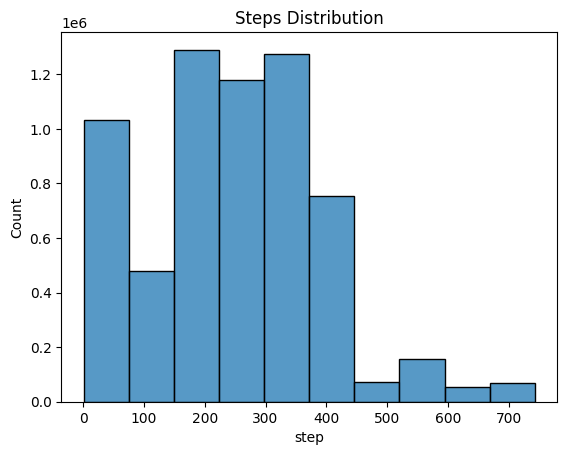

In [8]:
sns.histplot(data=ds, x='step', bins=10)
plt.title('Steps Distribution')
plt.show()

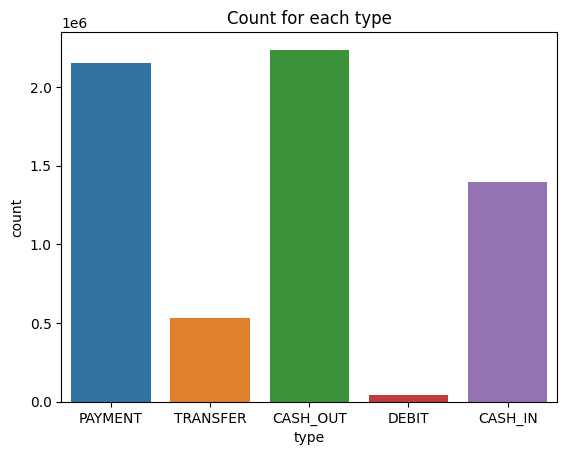

In [9]:
sns.countplot(data=ds, x='type')
plt.title('Count for each type')
plt.show()

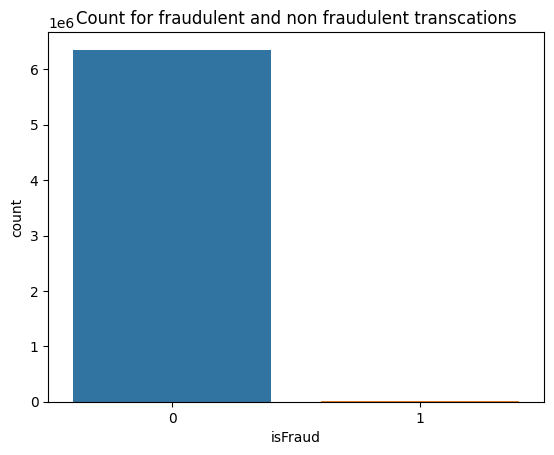

In [10]:
sns.countplot(data=ds, x='isFraud')
plt.title('Count for fraudulent and non fraudulent transcations')
plt.show()

The visualization shows us that there is a huge class imbalance in our dataset. This could affect our model's performance negatively.

In [11]:
ds['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

We have only 8213 fraudulent transactions in our dataset and more than 6 million non-fraudulent transactions. This will skew our model's performance negatively.

In [12]:
fraudulent = ds.loc[ds['isFraud'] == 1]
nonfraudulent = ds.loc[ds['isFraud'] == 0]

In [13]:
num_fraudulent = fraudulent.shape[0]

nonfraudulent = nonfraudulent.sample(num_fraudulent*2, random_state=1111)

In [14]:
print(len(fraudulent), len(nonfraudulent))

8213 16426


In [15]:
ds = pd.concat([fraudulent, nonfraudulent])

ds = ds.sample(frac=1, random_state=1111) ## Shuffle the dataset

ds.reset_index(drop=True, inplace=True)

In [16]:
ds.head()

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   253  CASH_OUT    93988.02  C1532332186           0.00            0.00   
1   334  CASH_OUT   972142.03   C129076810      972142.03            0.00   
2   209   PAYMENT     4520.78   C225563268       38830.31        34309.53   
3   307  TRANSFER  1072345.79   C114044821     1072345.79            0.00   
4   601  TRANSFER    74854.93   C865504538       74854.93            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0   C941330384     12709759.71     12803747.73        0               0  
1   C948349145            0.00       972142.03        1               0  
2  M1135283598            0.00            0.00        0               0  
3  C1178875500            0.00            0.00        1               0  
4   C682036673            0.00            0.00        1               0

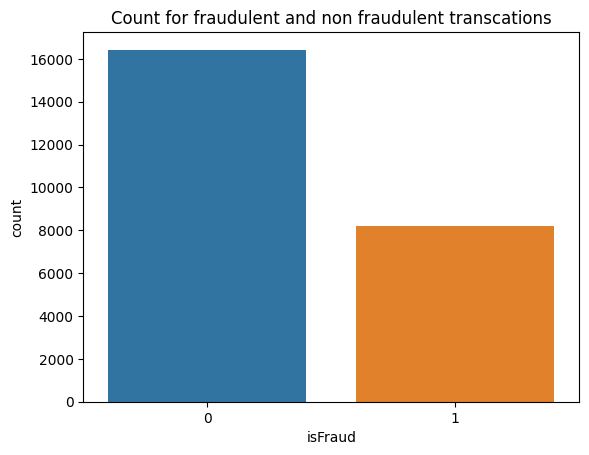

In [17]:
sns.countplot(data=ds, x='isFraud')
plt.title('Count for fraudulent and non fraudulent transcations')
plt.savefig('Count for fraudulent and non fraudulent transcations.jpg')
plt.show()

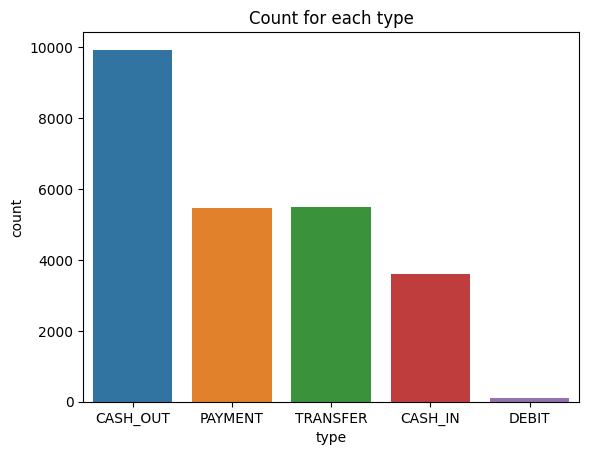

In [18]:
sns.countplot(data=ds, x='type')
plt.title('Count for each type')
plt.savefig('Count for each type.jpg')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


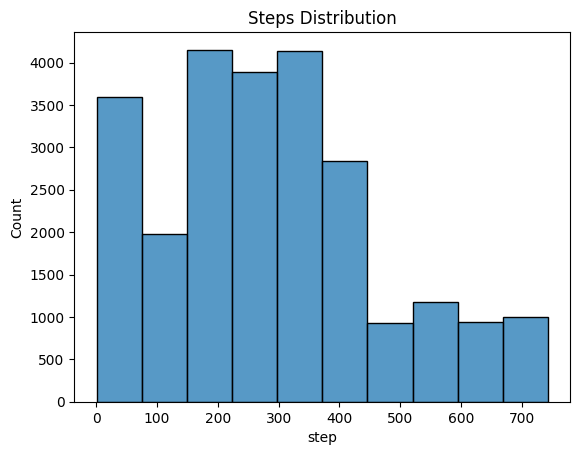

In [19]:
sns.histplot(data=ds, x='step', bins=10)
plt.title('Steps Distribution')
plt.show()

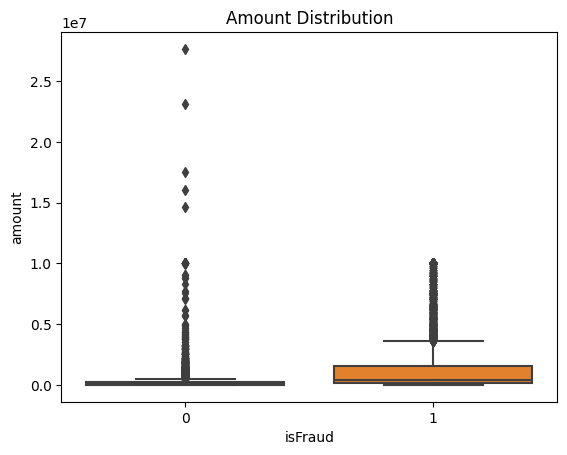

In [20]:
sns.boxplot(data=ds, y='amount', x='isFraud')
plt.title('Amount Distribution')
plt.show()

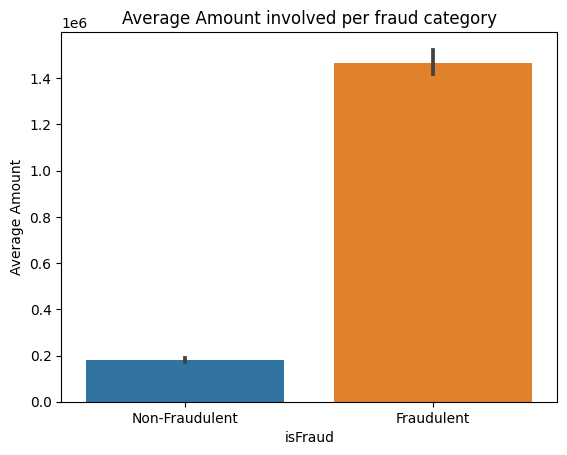

In [21]:
sns.barplot(data=ds, y='amount', x='isFraud')
plt.title('Average Amount involved per fraud category')
plt.xticks(labels=['Non-Fraudulent', 'Fraudulent'], ticks=[0, 1])
plt.ylabel('Average Amount')
plt.savefig('Average Amount involved per fraud category.jpg')
plt.show()

Based on the visualization, on average, fraudulent transactions usually involve much higher amounts than non fraudulent transactions.

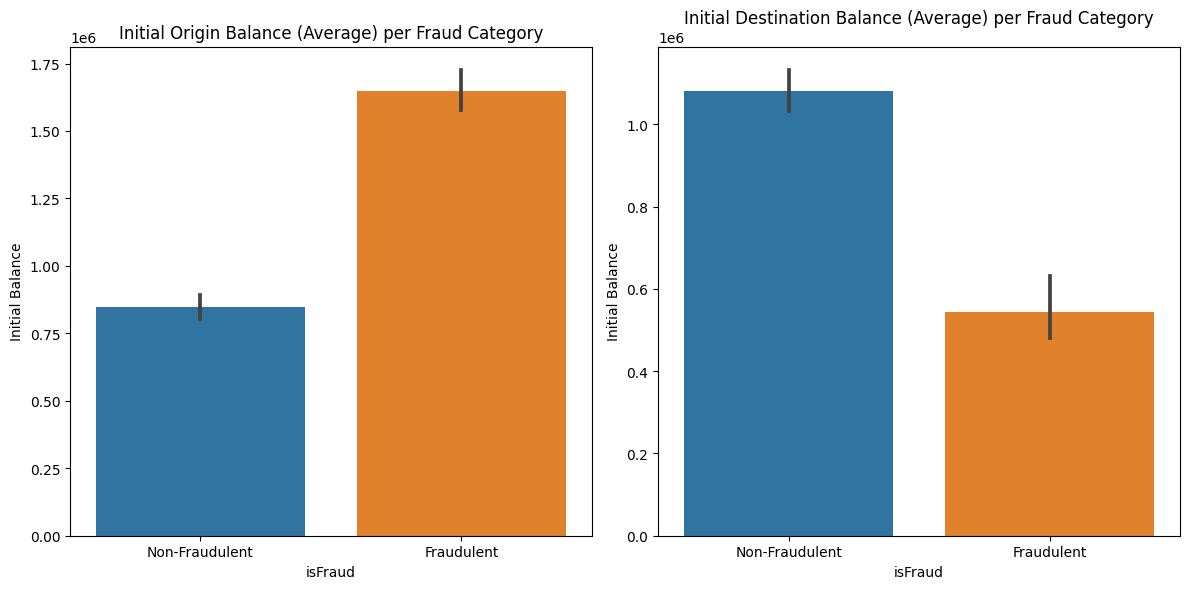

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(data=ds, y='oldbalanceOrg', x='isFraud', ax=axs[0])
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Non-Fraudulent', 'Fraudulent'])
axs[0].set_ylabel('Initial Balance')
axs[0].set_title('Initial Origin Balance (Average) per Fraud Category')

sns.barplot(data=ds, y='oldbalanceDest', x='isFraud', ax=axs[1])
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Non-Fraudulent', 'Fraudulent'])
axs[1].set_ylabel('Initial Balance')
axs[1].set_title('Initial Destination Balance (Average) per Fraud Category')

plt.tight_layout()

plt.savefig('Initial_Balance_Per_Fraud_Category.jpg')
plt.show()

Based on the visualization:
- The initial balance of accounts that initiate fraudulent transactions is much higher on average.
- The initial balance of accounts receiving fraudulent transactions is much lower on average.

## Feature Engineering and Extraction

In [22]:
ds.head()

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   253  CASH_OUT    93988.02  C1532332186           0.00            0.00   
1   334  CASH_OUT   972142.03   C129076810      972142.03            0.00   
2   209   PAYMENT     4520.78   C225563268       38830.31        34309.53   
3   307  TRANSFER  1072345.79   C114044821     1072345.79            0.00   
4   601  TRANSFER    74854.93   C865504538       74854.93            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0   C941330384     12709759.71     12803747.73        0               0  
1   C948349145            0.00       972142.03        1               0  
2  M1135283598            0.00            0.00        0               0  
3  C1178875500            0.00            0.00        1               0  
4   C682036673            0.00            0.00        1               0

In [23]:
copy = ds.copy()

In [24]:
copy.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1, inplace=True)

In [25]:
copy = pd.get_dummies(copy, drop_first=True, dtype='int')

In [52]:
X = copy.drop('isFraud', axis=1).values
y =copy['isFraud'].values

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
rfc = RandomForestClassifier(random_state=1111, max_depth=3)

rfc.fit(X, y)

RandomForestClassifier(max_depth=3, random_state=1111)

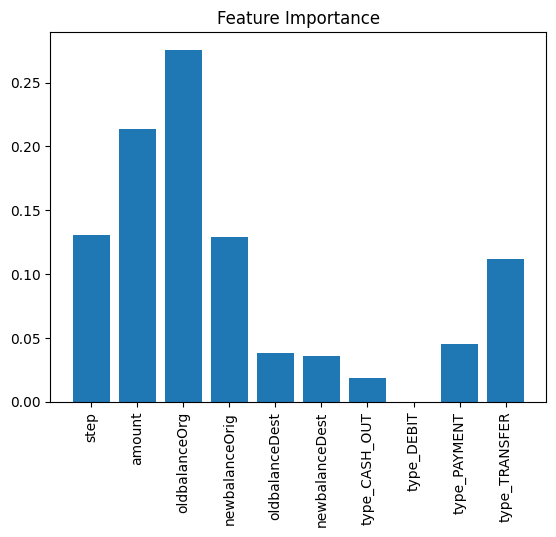

In [76]:
plt.bar(copy.drop('isFraud', axis=1).columns, rfc.feature_importances_)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.savefig('Feature Importance.jpg')
plt.show()

## Feature Importance

Based on the RandomForest model:
- The Old Balance of the account initiating the transaction is the most important feature.
- The amount involved is also a very important feature in determining if a transaction is fraudulent.
- Overall, the original account gives us a lot of information on if a transaction is fraudulent or not.

In [77]:
xgb_clf = XGBClassifier(random_state=111, max_depth=5, n_estimators=500)

cvscore = cross_val_score(xgb_clf, X, y, scoring='precision', cv=5, n_jobs=4)
print(f"Model Precision: {np.mean(cvscore)}")

Model Precision: 0.9888688319443919


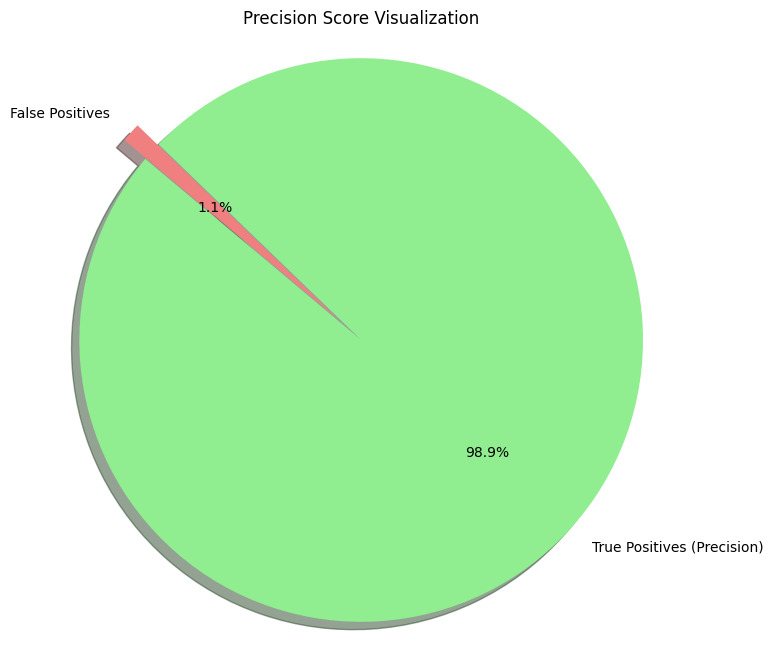

In [79]:
true_positives = np.mean(cvscore)
false_positives = 1 - true_positives

labels = ['True Positives (Precision)', 'False Positives']
sizes = [true_positives, false_positives]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Precision Score Visualization')
plt.axis('equal')

plt.savefig('precision_score_pie_chart.jpg')
plt.show()